#### Glassnode DS code challenge

___

In [1]:
# priting over 1 line of code within the same cell

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# importing required libraries
import pandas as pd
import numpy as np
from collections import defaultdict
import time
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

from IPython.display import Image


### Columns Description:

- |__Unnamed: 0__| -> Redundant column of the index. _'int64'_
- |__Hash__| -> The hash of this transaction. _'object'_
- |__Size__| -> The size of block data in bytes. _'int64'_
- |__Virtual size__| -> The virtual transaction size (differs from size for witness transactions). _'int64'_
- |__Version__| -> Protocol version specified in block which contained this transaction. _'object'_
- |__Lock time__| -> Earliest time that miners can include the transaction in their hashing of the Merkle root to attach it in the latest. _'object'_
- |__Block hash__| -> Hash of the block which contains this transaction. _'int64'_
- |__Block number__| -> Number of the block which contains this transaction. _'int64'_
- |__block timestamp__| -> Timestamp of the block which contains this transaction. _'object'_
- |__Block timestamp month__| -> Month of the block which contains this transaction. _'int64'_
- |__Input count__| -> The number of inputs in the transaction. _'int64'_
- |__Output count__| -> The number of outputs in the transaction. _'int64'_
- |__Input value__| -> Total value of inputs in the transaction in satoshis. _'int64'_
- |__Output value__| -> Total value of outputs in the transaction in satoshis. _'int64'_
- |__Is coinbase__| -> Max amount of sets that can be played in a match. _'bool'_
- |__Fee__| -> The fee paid by this transaction in sats. _'float64'_
- |__Inputs__| -> Transaction inputs. _'object'_
- |__Outputs__| -> Transaction outputs. _'object'_

_OUTPUTS_ :
- |__index:__| -> (numeric) Index of the tx. 
- |__script_asm__| -> (string) String representation of the script public key.
- |__script_hex__| -> (string) Hex string of the script public key. 
- |__required_signatures__| -> (numeric) The required signatures (always 1)
- |__type__| -> (string) The type of the script public key (e.g. witness_v0_keyhash or witness_v0_scripthash)
- |__address__| -> (json array) Basically amount of inputs.
- |__value__| -> (numeric) Amount of sats sent/received to that address

In [3]:
# couple of days of data converted to csv
df= pd.read_csv('../files/blocks_1.csv')

### __1.1 - What is currently the total amount of BTC recorded on the blockchain?__

In order to reply this question we would have to look at all the coins that have been 'released' or 'discovered' by miners. One way to solve this could be by adding up all values in `output_value` variable while filtering the DF by the `is_coinbase` column. Since the `output_value` also comes (in some cases) with the `fee` claimed by the miner it would be necessary to substract this value from the total.

In this specific example I used only data starting from May 2021.

<br>

Let's use SQL BigQuery directly from the Google's Cloud Platform to solve this question.

By the time I launched the query the block height was __687152__ (in Google's Database) while my own personal node said it was __687153__, and according to my node the amount of btc in circulation was __18,732,116.50__. So basically I missed the answer by few btc, this might be bcuz of some math I did wrong or...

But it raised some questions the fact that I was getting more bitcoin from Google's platform with allegedly less blocks mined...

Well, maybe there were some blocks mined while doing all of this... I wasnt exactly timing this.

In [7]:
query= '''SELECT SUM(reward) AS bitcoin_circulation
FROM (
    SELECT t1.block_number, t1.total_received, t2.fee_paid, (t1.total_received - t2.fee_paid) AS reward
FROM 
    (SELECT block_number, (SUM(output_value) / 100000000) as total_received, 
FROM `bigquery-public-data.crypto_bitcoin.transactions`A
WHERE is_coinbase IS TRUE
GROUP BY block_number) AS t1
JOIN 
    (SELECT block_number, SUM(output_value), (SUM(fee) / 100000000) AS fee_paid
FROM `bigquery-public-data.crypto_bitcoin.transactions` B
GROUP BY block_number) AS t2
ON t1.block_number = t2.block_number
ORDER BY t1.block_number
    ); '''

In [1]:
[
  {
    "bitcoin_circulation": "18732146.04497096"
  }
]

[{'bitcoin_circulation': '18732146.04497096'}]

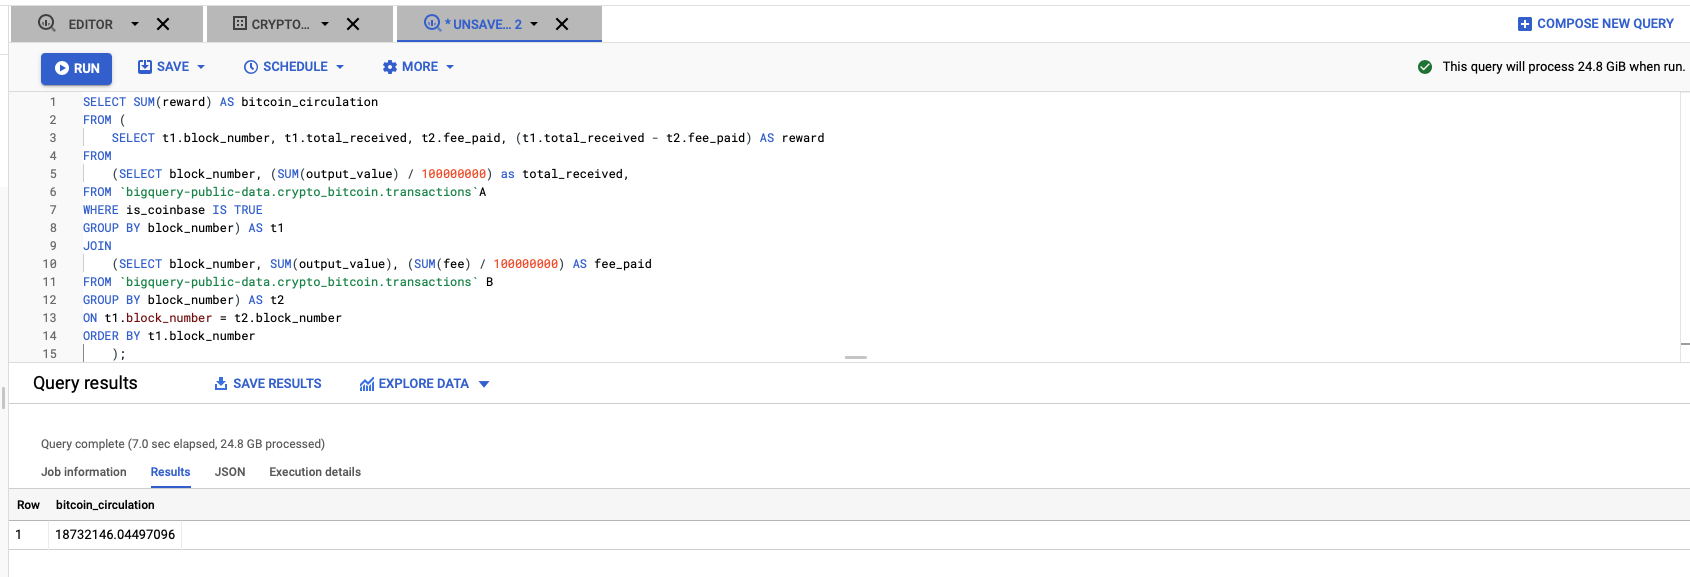

In [8]:
Image(filename='Q1.1.png') 

To solve this question I used a subquery, provably there's an easier/simpler/cleaner way to get to the final result. 

<br>

<br>

### __1.2 - What is currently the amount of unspent BTC that were created in coinbase transactions? In other words, we are interested in knowing the amount of mining rewards that have never left the mining address.?__

To tag this question, first I thought of building a table where I get the `address` where that specific mining reward went, taking into account the same problem as in the first question, that those output values most of the time come with the sum of the `fee` paid in transaction and claimed by the miners. This is not __always__ the case since some miners dont claim that fee to optimize the mining process.

In [ ]:
query= '''
SELECT t1.block_number, t1.total_received, t2.fee_paid, (t1.total_received - t2.fee_paid) AS reward
FROM 
    (SELECT block_number, (SUM(output_value) / 100000000) as total_received, 
    FROM `bigquery-public-data.crypto_bitcoin.transactions`A
    WHERE is_coinbase IS TRUE
    GROUP BY block_number) AS t1
JOIN 
    (SELECT block_number, SUM(output_value), (SUM(fee) / 100000000) AS fee_paid
    FROM `bigquery-public-data.crypto_bitcoin.transactions` B
    GROUP BY block_number) AS t2
    ON t1.block_number = t2.block_number
    ORDER BY t1.block_number;'''

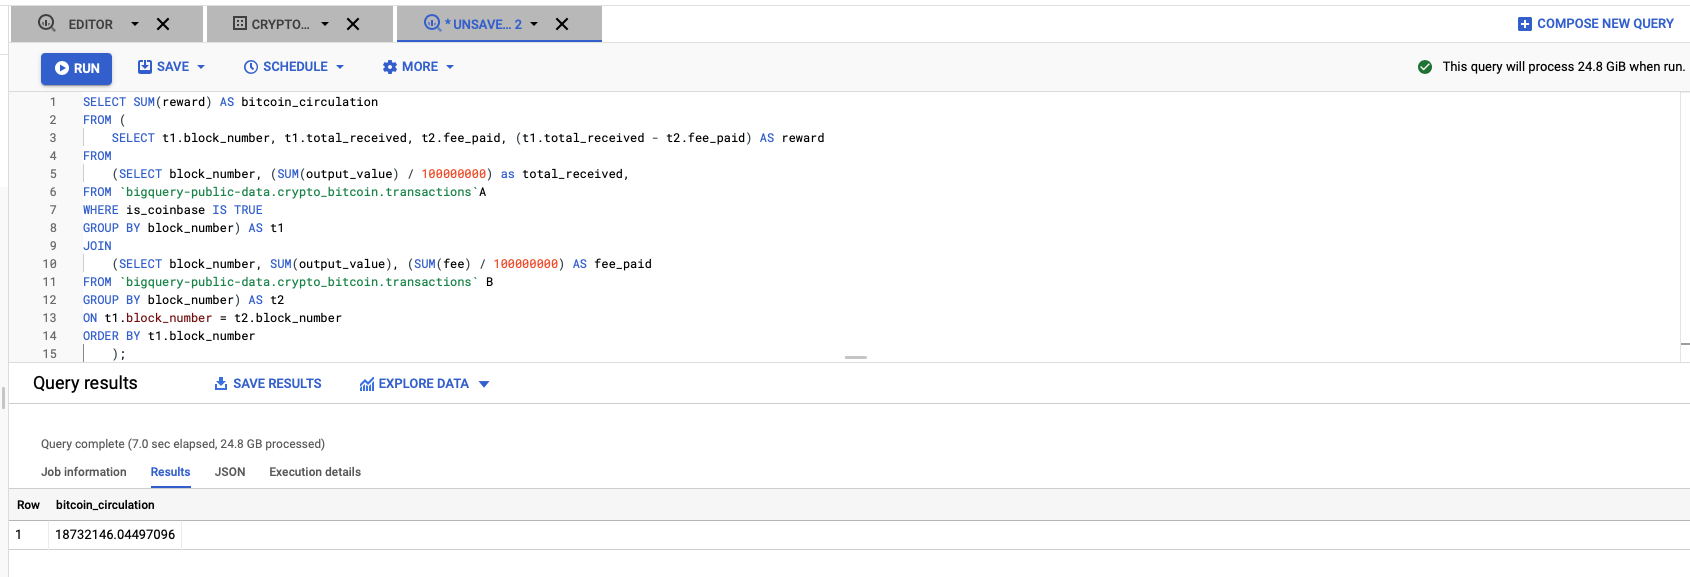

In [10]:
Image(filename='Q1.1.png') 

So to tag this question i first wanted to create a table where I grouped by `block_number` then have another variable for the block's subsidy and and the total `fee` paid on every block so i can make the computation and have the final result as `reward`.

Then I proceeded and join and unnested the `output` to get the address that received that reward under the condition that this should have a `value` > 0... Some `is_coinbase` transactions have several outputs but there was only one address with the proper reward, this is the address i was trying to tag!

For this question I circumvented the call and exploted the partitioning of the table transactions and restrict the processed data via a filter, e.g., `block_timestamp_month <= '2010-01-01'`. I sticked to `block_timestamp_month >= '2020-01-01'`

In [350]:
df.head(2)

,Unnamed: 0,hash,size,virtual_size,version,lock_time,block_hash,block_number,block_timestamp,block_timestamp_month,input_count,output_count,input_value,output_value,is_coinbase,fee,inputs,outputs,output_val_feeless,fee_block
0,0,9af5040f4be5c012d6c8488082f13076b7284035d7cbea...,370,370,2,0,00000000000000000001732fd87b83d81424376b900ef2...,679525,2021-04-14 23:51:48+00:00,2021-04-01,2,2,261486.0,225320.0,False,36166.0,"[{'index': 0, 'spent_transaction_hash': 'cce4e...","[{'index': 0, 'script_asm': 'OP_HASH160 c9e274...",189154.0,80095838.0
1,1,991a1d1239096f047bfaf85872b2e5a2fad43573b56878...,223,223,1,0,00000000000000000001732fd87b83d81424376b900ef2...,679525,2021-04-14 23:51:48+00:00,2021-04-01,1,2,536063.0,518661.0,False,17402.0,"[{'index': 0, 'spent_transaction_hash': '13a89...","[{'index': 0, 'script_asm': 'OP_DUP OP_HASH160...",501259.0,117947707.0


In [336]:
df['fee_block']

0          80095838.0
1         117947707.0
2          98884496.0
3          99546576.0
4          93644037.0
             ...     
581566            NaN
581567            NaN
581568            NaN
581569            NaN
581570            NaN
Name: fee_block, Length: 581571, dtype: float64

In [281]:
fee_per_block= df.groupby('block_number').sum()['fee']

In [286]:
fee_per_block= pd.DataFrame(fee_per_block)

In [288]:
fee_per_block.reset_index(inplace= True)

In [290]:
fee_per_block.head()

,block_number,fee
0,679250,80095838.0
1,679251,117947707.0
2,679252,98884496.0
3,679253,99546576.0
4,679254,93644037.0


___

__What is currently the amount of **unspent** BTC that were created in coinbase transactions?__

Since the inputs/outputs columns of the DF that extracted from the cloud doesnt come in a decent format that can be easily parse using json or simple dict I will be converting the string into a list of dicts to keep important values.

In [10]:
# Converts the string on each road of the selected columns into a list of well-formed dictionaries.

def clean_columns(x, index):
    y = x[index]
    
    if y == "[]":
        return x
    chars_to_replace = "[{'}]\n( " # unnecessary characters that belonged to bigquery json format.

    words_to_replace = ["array", "dtype=object", "Decimal", ")index"] # 'change' chars that are useless. 

    
    for char in chars_to_replace:
        y = y.replace(char, "")

    for word in words_to_replace:
        y = y.replace(word, "")
        
    y = y.replace(")", "")

    inputs_dict = defaultdict(list)
    rep_text = y.split(":")
    inputs_dict[rep_text[0]].append(rep_text[1][0])
    for i, thing in enumerate(rep_text):
        if i == 0:
            continue
        thing = thing.split(",")
        
        if i == 1:
            last_thing = thing[1]
            #inputs_dict[last_thing] = []
        else:
            try:
                thing[0] = int(thing[0])
            except ValueError:
                pass
            
            inputs_dict[last_thing].append(thing[0])
            try:
                last_thing = thing[1]
            except IndexError as error:
                inputs_dict["values"].append(thing[0])

    inputs_dict["index"] = list(range(len(inputs_dict["required_signatures"])))
    inputs_dict["values"] = [float(value.replace("E", "e").split(".")[0]) for value in inputs_dict["values"]]
    inputs_dict["hash"] = [x[1]] * len(inputs_dict["index"])
    [inputs_dict.pop(key) for key in list(inputs_dict.keys()) if key not in ["hash", "sequence", "spent_output_index", "spent_transaction_hash", "type", "values", "addresses"]]
    #keeping only neccesary columns for our product
    
    
    return inputs_dict

<br>

In [11]:
# apply it on the inputs/outputs

start = time.time()

outputs = df.apply(clean_columns, axis=1, index=-1) # parse "outputs" columns
inputs = df.apply(clean_columns, axis=1, index=-2) # parse "inputs" columns

print('This piece of code took: ',time.time() - start , 'to run')

This piece of code took:  127.92587900161743 to run


In [49]:
# apply it on the coinbase inputs/outputs

start = time.time()

cb_outputs = rewards.apply(clean_columns, axis=1, index=-1) # parse "outputs" columns

print('This piece of code took: ',time.time() - start , 'to run')

This piece of code took:  0.40710878372192383 to run


In [13]:
# expanding dicts
# this line will take some computational power

df_outputs = []
df_inputs = []

start = time.time()
for i in range(outputs.shape[0]):
    df_outputs.append(pd.DataFrame.from_dict(outputs.iloc[i]))

print('Outputs: ', time.time() - start)

start = time.time()
for i in range(inputs.shape[0]):
    
    #if len(inputs.iloc[i].keys()) == 7: # remove entries without inputs (rewards for mining a block)
    df_inputs.append(pd.DataFrame.from_dict(inputs.iloc[i]))

print('Inputs: ', time.time() - start)

Outputs:  340.3598999977112
Inputs:  503.6338939666748


In [15]:
# converting to df

start = time.time()
outputs = pd.concat(df_outputs)
print('Outputs: ', time.time() - start)
start = time.time()
inputs = pd.concat(df_inputs)
print('Inputs: ', time.time() - start)

Outputs:  782.9648199081421
Inputs:  1081.5636751651764


In [37]:
# expanding dicts
# this line will take some computational power

df_cb_outputs = []

start = time.time()
for i in range(cb_outputs.shape[0]):
    df_cb_outputs.append(pd.DataFrame.from_dict(cb_outputs.iloc[i]))

KeyboardInterrupt: 

<br>

In [128]:
df_cb_outputs[0]

,type,addresses,values,hash
0,pubkeyhash,12dRugNcdxK39288NjcDV4GX7rMsKCGn6B,705095838.0,d6d1657b097ad17d401c47a36214a72d1184d745339828...
1,nonstandard,nonstandardceaddf7de932b07ef97c8f3da46358e00e4...,0.0,d6d1657b097ad17d401c47a36214a72d1184d745339828...
2,nonstandard,nonstandard884c752af4b81e3bfb467f2492293269bf4...,0.0,d6d1657b097ad17d401c47a36214a72d1184d745339828...
3,nonstandard,nonstandarda52e4352c974b5c7c7f33af6e3e5adc2da9...,0.0,d6d1657b097ad17d401c47a36214a72d1184d745339828...


In [129]:
df_cb_outputs = pd.concat(df_cb_outputs)

In [134]:
df_cb_outputs= df_cb_outputs[df_cb_outputs['values'] > 0]

In [190]:
(df_cb_outputs['values'].sum() - df['fee'].sum()) / 100000000

1725.0

In [137]:
df_cb_outputs.head(1)

,type,addresses,values,hash
0,pubkeyhash,12dRugNcdxK39288NjcDV4GX7rMsKCGn6B,705095838.0,d6d1657b097ad17d401c47a36214a72d1184d745339828...


In [210]:
df_inputs = pd.concat(df_inputs)

In [234]:
cond = df_cb_outputs['addresses'].isin(df_inputs['addresses'])

In [241]:
holder_outputs= df_cb_outputs.drop(df_cb_outputs[cond].index)

In [243]:
len(holder_outputs)

44

In [351]:
holder_outputs['values']

32416451365.0

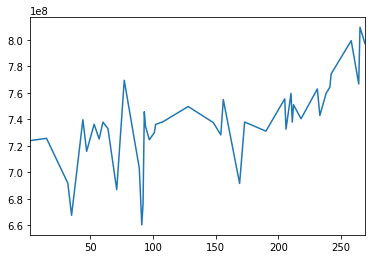

In [354]:
holder_outputs['values'].plot()

## 2 - Blockchain Archaeology

ERROR 505 when parsing bitcoincharts

`3M219KR5vEneNb47ewrPfWyb5jQ2DjxRP6`

### __- Over which time periods does to address hold funds?__

__First time receiving__: 2018-11-14 13:21:45 

__Last time sending__: 2021-04-19 03:41:52 (emptied)

Worth noticing that this address (apperently one of Binance's Cold Wallets) made a lot of movements over that period of time, they emptied and filled the address with coins several times (address reused).

<br>

### __- How does its balance increase or decrease?__

It received a total of: 1,485,097.16081355 Ƀ (summed)

It sent the same amount

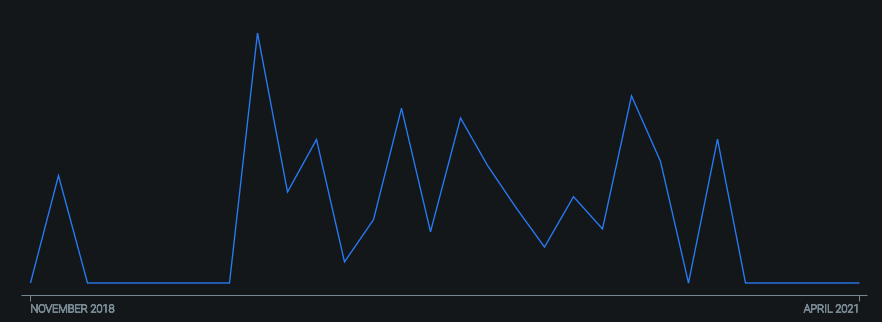

In [3]:
Image(filename='graph1.png') 

<br>

### __- What are common trading partners, i.e. addresses it is interacting with?__

Seems like this is like a sort of 'bridge wallet' that binance uses to interact mostly with other cold wallets or main exachange wallet?  i.e ['1NDyJtNTjmwk5xPNhjgAMu4HDHigtobu1s', '34xp4vRoCGJym3xR7yCVPFHoCNxv4Twseo']. Two common addresses that exchange a lot with the one analized.

<br>

### __- Which transactions would you rate as interesting and why?__

Considering this is a cold wallet of one of the largest exchanges out there, the inflow/outflow of big amounts to other wallets related to the exchange is pretty standard. I would be more inclined to understand what are those very small transactions the wallet recevided several times... Those usually came from unknown wallet and had many many outputs... Maybe spam? Maybe some chainanalysis? 

<br>

### __- What are typical transferred values?__

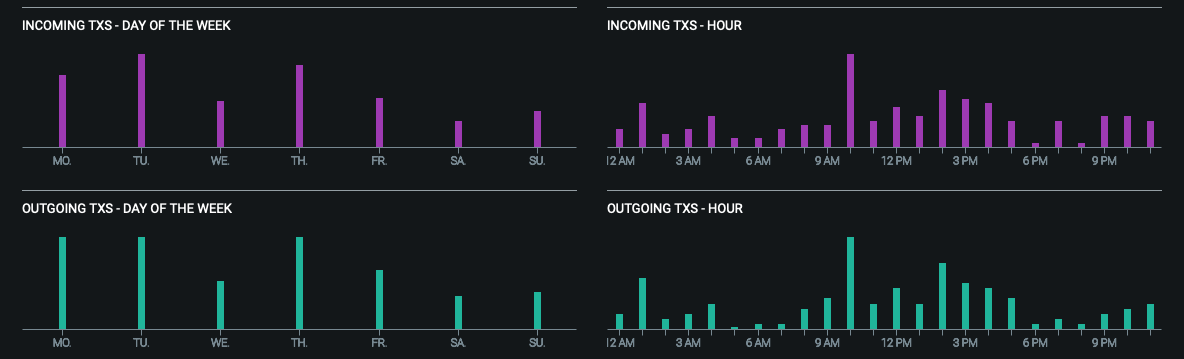

In [4]:
Image(filename='graph2.png') 

Typically the largest movements in volume terms of this address is on Mondays, Tuesdays and Thursdays at approx 10am. Appart from this, value transacted tend to be btween 1-5k btc with some outliers that go as high as 66k on 2019-05-31.

<br>

### __- Are there outliers with respect to the transferred values? If yes, what could they indicate?__

My guess is that it was just reaccommodation of funds or maybe they started using better practices when it comes to funds accommodation, the biggest outlier we have in the wallet is 66k btc sent to these 2 outputs: '1NDyJtNTjmwk5xPNhjgAMu4HDHigtobu1s' (binance wallet A) and '3L7HUuwH96VkvAi3o9mxbvbz1UCEY4Z89B' (unknown). 

If one keeps track of the 2nd address it is easily recognizable that it sends btc periodically to '1NDyJtNTjmwk5xPNhjgAMu4HDHigtobu1s' but the change its sent again to a new Segwit address, so prolly that, just a better practice when it comes to storing funds.


<br>

### __- If you know some "best practices" for Bitcoin addresses, how would you rate the general behavior?__

Wallet reuse is crazy at this point but i also think that's also part of the business, maybe they need to keep that wallet and some important funds they control for their clients or users at sight and easily spotable.


<br>

### __- Can the owner of the address be identified?__

Totally... Its kindda impossible at this point to be an exchange and have that amount of money out of the loop.


<br>

### __- Can you spot any interesting patterns which might help you to identify addresses that are somehow similar or belong to the same owner?__

There are a few... Volume sent and receive is pretty much the same and that's very telling. Always exchanging with the same addresses. The temporal patters are pretty standard, send/receive money in the morning of Europe and most likely internal tx and during weekdays, especially on Tuesday and Thursday. 

<br>

### __- Here's a second address to investigate: `3BMEXYAk2tXXG5dS21fz2v7G7cBsZyUuUr`. What is different?__

A bitmex address and almost everything is different, volume, amount, fees, patters, this one is a 3-4 multi-sig add. Also as far as im concerned, many if not all Bitmex addresses start with 3BMEX...